In [1]:
import numpy as np
import pickle
import pandas as pd
from scipy.interpolate import interp1d
from numpy.linalg import norm
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import itertools
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution

%load_ext line_profiler
#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

In [2]:
cmsFile = './HEPData-ins1894408-v2-csv/DeepAK8taggingefficiencies.csv'

In [3]:
with open(cmsFile,'r') as f:
    data = f.read()
    blocks = data.split('#: Process')[1:]

In [4]:
for ib,b in enumerate(blocks):
    blocks[ib] = [l for l in b.split('\n') if l.strip()]

In [5]:
# Collect data:
data = []
for b in blocks:
    mode = b[0].replace(',','').strip()
    period = eval(b[1].split(',')[-1])
    wpoint = b[2].split(',')[-1].strip()
    pts = np.array([[eval(val) for val in x.split(',')] for x in b[4:]])
    if 'W' in mode:
        pid = 24
    elif 'Z' in mode:
        pid = 23
    else:
        pid = 0
    data.append({'mode' : mode, 'Data-taking period' : period, 
                 'Working point' : wpoint, 'Data' : pts, 'PID' : pid})

In [6]:
# Creater interpolating functions
fInterp = {}
for d in data:
    x = d['Data'][:,0]
    y = d['Data'][:,-1]
    pid,dt,wpoint = d['PID'],d['Data-taking period'],d['Working point']
    f = interp1d(x,y,bounds_error=False,fill_value=(0.,y[-1]))
    fInterp[(pid,dt,wpoint)] = f
    
# Save interpolation functions
with open('deepAK8effs.pcl','wb') as ff:
    pickle.dump(fInterp,ff)
    

In [7]:
with open('deepAK8effs.pcl', 'rb') as ff:
    fInt = pickle.load(ff)
    
def deepAK8effs(pT,pid=23,dt=2017,wpoint='tight'):
    f = fInt[(abs(pid),dt,wpoint)]
    eff = min(1.0,max(0.,f(pT)))
    eff = float(eff)
    
    return eff
    

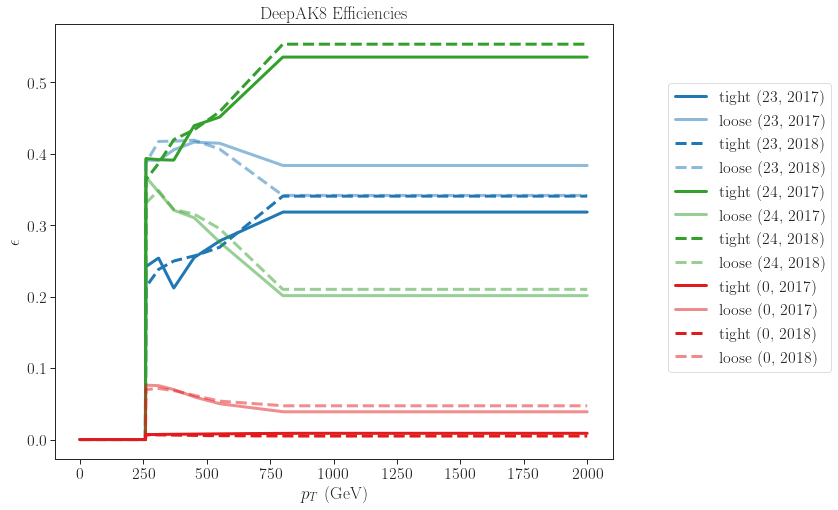

In [8]:
f = plt.figure(figsize=(10,8))
pT = np.linspace(0.,2000.,1000)
pids = [23,24,0]
dts = [2017,2018]
wpoints = ['tight','loose']
colors = sns.color_palette("Paired",7)[1:][::2]
colors = {pid : colors[i] for i,pid in enumerate(pids)}
alphas = {'tight' : 1.0, 'loose' : 0.5}
lstyles = {2017 : '-', 2018 : '--'}
for pid,dt,wpoint in itertools.product(pids,dts,wpoints):
    eff = [deepAK8effs(x,pid,dt,wpoint) for x in pT]
    c = colors[pid]
    alpha = alphas[wpoint]
    ls = lstyles[dt]
    plt.plot(pT,eff,label = '%s (%s, %s)' %(wpoint,pid,dt),
             linewidth=3,alpha=alpha,linestyle=ls,c=c)
    
plt.xlabel(r'$p_{T}$ (GeV)')
plt.ylabel(r'$\epsilon$')
plt.title('DeepAK8 Efficiencies')
# plt.yscale('log')
plt.legend(loc=(1.1,0.2))
plt.show()